<h1 align="center"> 10X Genomics scRNA-seq Analysis in Python </h1>

---

#### Course Instructor: Albert S W Kang (swk30@cam.ac.uk)

For this tutorial, we are using the `10k Brain Cells from an E18 Mouse (v3 chemistry)` dataset:
- https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_10k_v3

As specified on the webpage, the link contains the single-cell gene expression dataset of cells from a combined cortex, hippocampus and sub-ventricular zone of an E18 mouse:
- 11,843 cells detected
- Illumina NovaSeq with approximately 30,000 reads per cell
- **28bp** `read1` (16bp Chromium barcode + 12bp UMI), **91bp** `read2` (transcript) and **8bp** I7 sample barcode

`Cell Ranger` is a set of analysis pipelines that can process Chromium single-cell RNA-seq output to align reads and generate feature-barcode matrices from BCL and FASTQ files. We are going to do the analyses ourselves so we just want the feature-barcode matrix:
- `Feature / cell matrix HDF5 (filtered)` - .h5 file

## A - Quick Introduction to 10X Chromium Platform

A single mammalian cell only has ~10 pg of total RNA and less than 0.1 pg of mRNA. This is a bit of a problem as RNA-seq usually requires microgram amounts of total RNA for analysis, which equals the total content of millions of cells. The roadmap of the solution is simple - mRNA is reverse transcribed into cDNA, the cDNA library is amplified prior to deep sequencing. The question is really on how we can get a good coverage of the transcriptome with high molecular sensitivity and less technical noise.

There are two commonly used RNA amplification strategies in scRNA-seq: 
- PCR-based amplification of full-length cDNA - '**template-switch based**': SmartSeq2, DropSeq
- Linear isothermal amplification by T7-based in vitro transcription - '**T7 based**'): InDrop

The `Chromium Single Cell 3′ Solution` is a commercial platform developed by 10x Genomics for preparing single cell cDNA libraries. It is essentially a combination of the two strategies (DropSeq and InDrop).
1. Reaction vesicles called GEMs (Gel Bead-In-Emulsions) are formed in a microfludic chip. It is a mixture of:
    - Gel beads (containing barcoded oligos)
    - Oil surfactant
    - Suspended cells with reverse transcription (RT) reagents
<img src="./img/Step-1.png" width=550>
2. RT initiated inside each GEM with primers containing Illumina adaptors, 10X barcodes, UMIs, and oligo(dT) sequences
    - All fragments from the same GEM share a common 10x barcode
<img src="./img/Step-2.png" width=550>
3. GEMs are broken and barcoded cDNAs are pooled for amplification and library construction. The library is sequenced then analysed.
<img src="./img/Step-3.png" width=300>

The 10X Genomics platform boasts up to 65% single cell capture rate and the entire library preparation can be completed within a day.

## B - Explore Matrix Output File

In [1]:
# Import modules

%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp_sparse
import h5py

# File location

filtered_matrix_h5_file = './data/neuron_10k_v3_filtered_feature_bc_matrix.h5'

# Data structure for the gene-barcode matrix

FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['feature_ids', 'feature_names', 'barcodes', 'matrix'])

# Helper function

def get_matrix_from_h5(filename):
    with h5py.File(filename) as f:
        if u'version' in f.attrs:
            if f.attrs['version'] > 2:
                raise ValueError('Matrix HDF5 file format version (%d) is an newer version that is not supported by this function.' % version)
        else:
            raise ValueError('Matrix HDF5 file format version (%d) is an older version that is not supported by this function.' % version)
        
        feature_ids = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['id']]
        feature_names = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['name']]        
        barcodes = list(f['matrix']['barcodes'][:])
        matrix = sp_sparse.csc_matrix((f['matrix']['data'], f['matrix']['indices'], f['matrix']['indptr']), shape=f['matrix']['shape'])
        return FeatureBCMatrix(feature_ids, feature_names, barcodes, matrix)
    
# Read-in file

%time feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5_file)

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


Wall time: 9.01 s


### Plot features from matrix

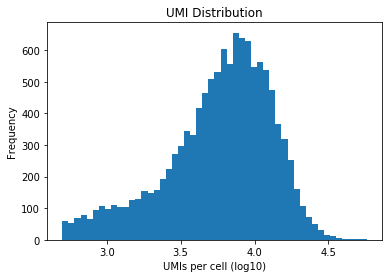

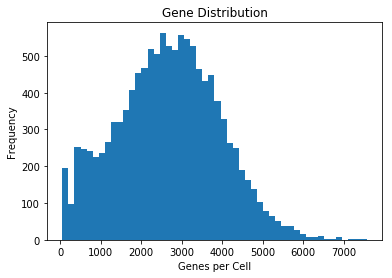

In [2]:
# Calculate UMIs and genes per cell

umis_per_cell = np.asarray(feature_bc_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((feature_bc_matrix.matrix > 0).sum(axis=0)).squeeze()

# Plot UMIs per cell

plt.hist(np.log10(umis_per_cell), bins=50)
plt.xlabel('UMIs per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

# Plot genes per cell

plt.hist(genes_per_cell, bins=50)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

## C - Analysis with `scanpy`

`scanpy` is a Python toolkit for analysing Chromium single-cell data. The nice thing about this package is that the API design is super user-friendly. Functions are organised into groups (pre-processing - **scanpy.pp**, statistics - **scanpy.tl**, and plotting - **scanpy.pl**) that make it easy to string them together into a standard analysis pipeline.

The main datatype that we have to play with is an object called `AnnData`, a generic class for handling annotated data matrices.

It stores:
- Observations (samples, cells): `adata.obs` - `pd.DataFrame`
- Variables (features, genes): `adata.var` - `pd.DataFrame`
- Data matrix: `adata.X` - `numpy.array`
    - Shape: (*# of observations*, *# of variables*)
- Unstructured annotation: `adata.uns` - `Dict`

### 0. Import data

In [3]:
# Required libraries

import pandas as pd
import scanpy as sc

# Read-in h5 file

adata = sc.read_10x_h5(filtered_matrix_h5_file)

# Make variable name unique

adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### 1. Pre-processing

First, let's have a quick look at the genes that have the highest fraction of counts in each single cell, across all cells.

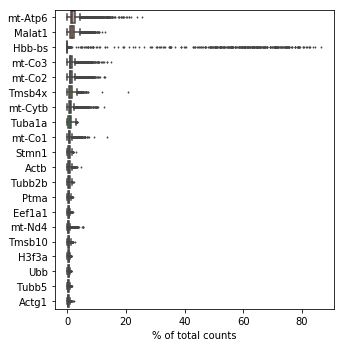

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20)

### 1.1 Quality Control (QC)

### Cell QC

Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial.

**1. Mitochondrial counts**

A high fraction of mitochondrial reads being picked up can indicate cell stress (less mRNA to be captured in the nucleus) or loss of cytoplasmic RNA from perforated cells (mitochondria are larger than individual transcript molecules and so are less likely to escape through tears in the cell membrane).

**2. Cell counts**

Histograms of the number of counts per cell may show important features for QC. To look out for are the extremities of the counts. If there are small cell groups at the lower end outside the general distribution of cells, these are likely to be uninformative potentially due to cellular debris found in droplets - in our dataset we do not see this. On the upper end of counts, we see a population of cells with high counts shown as a broad peak at 20,000 counts.

**3. Gene counts**

A population of cells with low gene counts can be seen in the plot below. It may be a good idea to filter out cells with fewer than 1000 genes expressed - below this we are likely to find dying cells or empty droplets with ambient RNA.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


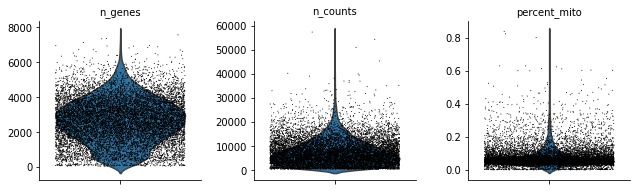

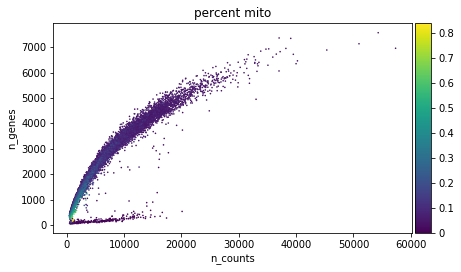

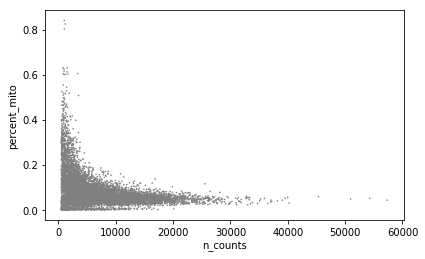

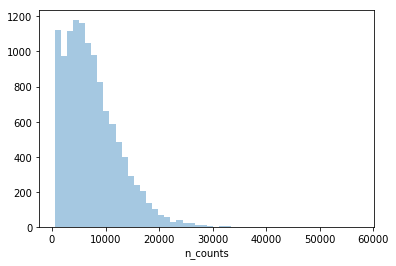

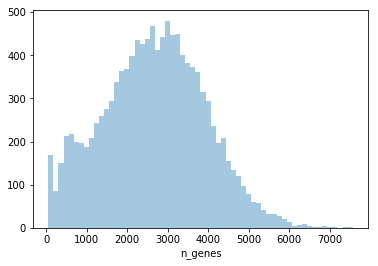

Total number of cells: 11843
Number of cells after max count filter: 11525
Number of cells after MT filter: 10953
Number of cells after gene filter: 10010


In [5]:
# Import seaborn

import seaborn as sb

# Calculate QC covariates

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = (adata.X > 0).sum(1).A1

# Data quality summary plots

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
plt.show()

# 1. Mitochondrial count plots

sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
plt.show()
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
plt.show()

# 2. Cell count plots

sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

# 3. Gene count plots

sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

# Filter cells according to identified QC thresholds

print('Total number of cells: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))
adata = adata[adata.obs['percent_mito'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

### Gene QC

Based on the thresholds we identified from the QC plots above, genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes, and genes which are not sufficiently informative of the dataset.

In [6]:
# Filter genes

print('Total number of genes: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31053
Number of genes after cell filter: 15014


### 1.2 Normalisation

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. 

In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

In [7]:
# Assuming all size factors are equal - library size normalisation to counts per million (CPM)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Normalise data distributions - log-transformation of the count data with an offset of 1 (such that 0 counts map to 0s)

sc.pp.log1p(adata)

# Store the full data set in 'raw' for statistical tests and visualisation

adata.raw = adata

### 1.3 Identify Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 2000 and 6000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all or the majority of these.

The plots below show how the data was normalised to select for highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Number of highly variable genes: 3999


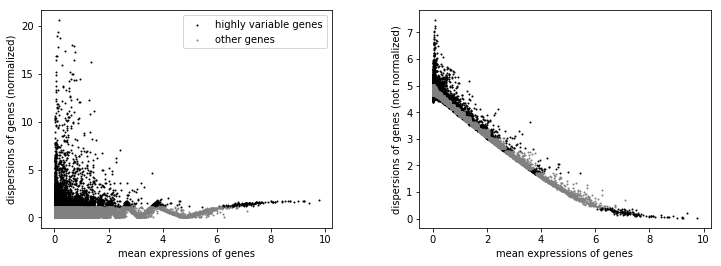

In [8]:
# Check highly variable genes

disp_filter = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=4000, log=False)
print('Number of highly variable genes: {:d}'.format(adata[:, disp_filter['gene_subset']].n_vars))

# Plot the highly variable genes

sc.pl.filter_genes_dispersion(disp_filter)

# Store HVG information ('adata.var' now has keys: ['highly_variable', 'means', 'dispersions', 'dispersions_norm'])

sc.pp.filter_genes_dispersion(adata, flavor='cell_ranger', n_top_genes=4000, log=False, subset=False)

# Filter

adata = adata[:, adata.var['highly_variable']]

# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed

sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

# Scale each gene to unit variance, clipping values exceeding standard deviation of 10

sc.pp.scale(adata, max_value=10)

### 2. Visualisation by Dimensionality Reduction

When analysing the distribution of cell states from single-cell gene expression data, two features are of principal interest. First, classifying cells into discrete clusters can give a coarse-grained representation of diﬀerent phenotypic states (e.g. cell types in a tissue). Second, understanding how cells link together to form continuous topologies can reveal dynamic behaviors during development, diﬀerentiation and perturbation response.

Common plots:
1. **PCA**:
    - Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
    - The plot does not show the expected clustering of the data in two dimensions
2. **t-SNE**:
    - Shows several distinct clusters with clear subcluster structure
    - Connections between clusters are difficult to interpret visually
3. **UMAP**:
    - Data points are spread out on the plot showing several clusters
    - Connections between clusters can be readily identified
4. **Diffusion Maps**:
    - Shows connections between regions of higher density
    - Very clear trajectories are suggested, but clusters are less clear
    - Each diffusion component extracts heterogeneity in a different part of the data


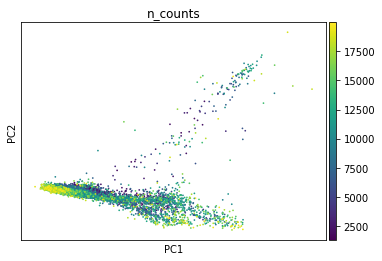

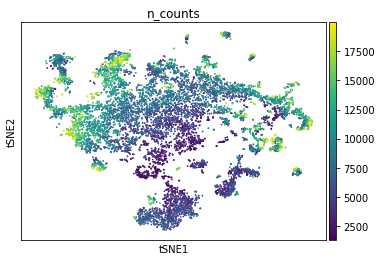

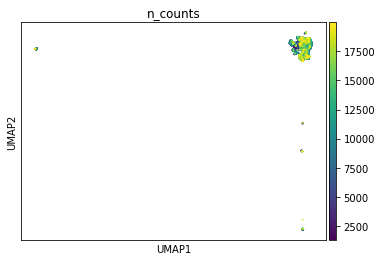

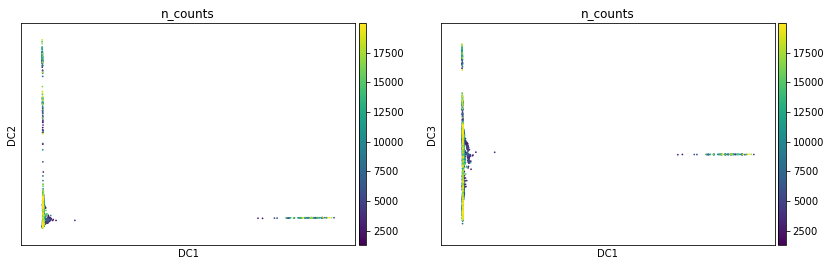

In [9]:
# PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_scatter(adata, color='n_counts', use_raw=False)
plt.show()

# t-SNE
sc.tl.tsne(adata)
sc.pl.tsne(adata, color='n_counts', use_raw=False)
plt.show()

# UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='n_counts', use_raw=False)
plt.show()

# Diffusion map
sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color='n_counts', use_raw=False, components=['1,2','1,3'])
plt.show()

### 3. Clustering

One of the most popular uses of scRNA-Seq is to identify and characterise cell-populations. From a biological point of view, cell-populations are often different cell-types (e.g. neurons and glia in a brain sample), but they can also correspond to different states of identical cell-types (e.g. stimulated and unstimulated T-cells). 

Several clustering methods have been explored:
1. **K-means**: *SC3*
2. **Hierarchical clustering**: *pcaReduce*
3. **Density-based clustering**: *Seurat*
4. **Graph clustering** - “community detection”: *Louvain*

Performing modularity optimisation by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

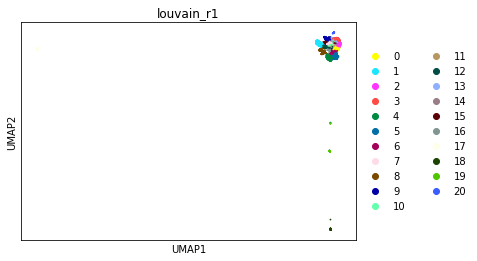

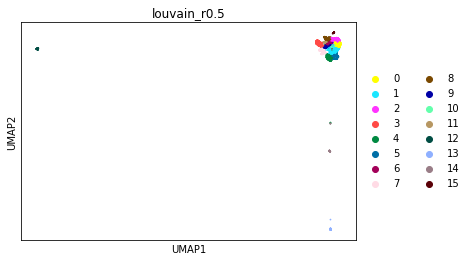

In [30]:
# Perform clustering

sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

# Plot clusters

sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['louvain_r0.5'], palette=sc.pl.palettes.default_64)

### 4. Gene-Level Analysis

Interpreting groups identified by a clustering algorithm is not trivial. Firstly, due to the heuristic nature of clustering algorithms, they will always find some partitioning, even if presented with data generated from a uniform distribution. In addition, even when clusters are a result of biological effects, rather than noise, those effects may not represent differences in cell-type.

#### **Differential Gene Expression**

To annotate the clusters we obtained, we find genes that are up-regulated or down-regulated in the cluster compared to all other clusters (marker genes). 

This test is automatically performed on the .raw data set, which is uncorrected and contains all genes. We take all genes into account as any gene may be an informative marker. You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 as an alternative to the Wilcoxon test used here.

C:\Users\User\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:192: RuntimeWarning: overflow encountered in int_scalars
  denominator_dof = (np.square(vars[igroup]) / (np.square(ns_group)*(ns_group-1))) + (
C:\Users\User\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:193: RuntimeWarning: overflow encountered in int_scalars
  (np.square(var_rest) / (np.square(ns_rest) * (ns_rest - 1))))


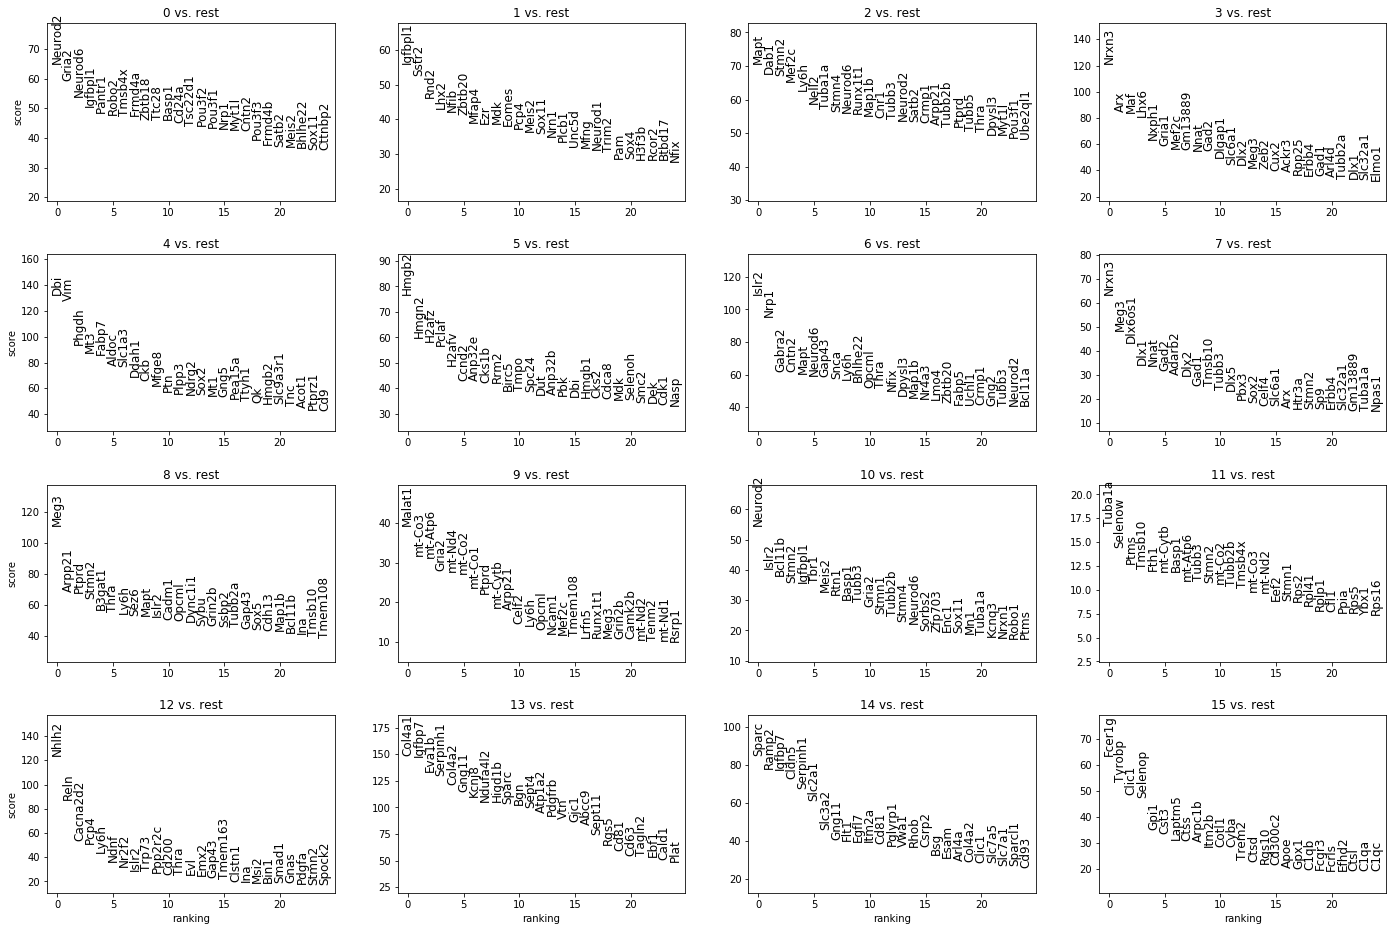

In [11]:
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5_wilcoxon', method='t-test')
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5_wilcoxon', n_genes=25, sharey=False, fontsize=12)

The p-values and the gene symbol is stored in a DataFrame and can be retrieved. For instance, if we want to show the 5 top-ranked genes per cluster:

In [12]:
pd.DataFrame(adata.uns['rank_genes_r0.5_wilcoxon']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Neurod2,Igfbpl1,Mapt,Nrxn3,Dbi,Hmgb2,Islr2,Nrxn3,Meg3,Malat1,Neurod2,Tuba1a,Nhlh2,Col4a1,Sparc,Fcer1g
1,Gria2,Sstr2,Dab1,Arx,Vim,Hmgn2,Nrp1,Meg3,Arpp21,mt-Co3,Islr2,Selenow,Reln,Igfbp7,Ramp2,Tyrobp
2,Neurod6,Rnd2,Stmn2,Maf,Phgdh,H2afz,Gabra2,Dlx6os1,Ptprd,mt-Atp6,Bcl11b,Ptms,Cacna2d2,Eva1b,Igfbp7,Clic1
3,Igfbpl1,Lhx2,Mef2c,Lhx6,Mt3,Pclaf,Cntn2,Dlx1,Stmn2,Gria2,Stmn2,Tmsb10,Pcp4,Serpinh1,Cldn5,Selenop
4,Pantr1,Nfib,Ly6h,Nxph1,Fabp7,H2afv,Mapt,Nnat,B3gat1,mt-Nd4,Igfbpl1,Fth1,Ly6h,Col4a2,Serpinh1,Gpi1


#### **Geneset Signature Enrichment Analysis**

Before we can move on to looking at gene sets, we have to first aggregate the gene expression data for each of the cluster:

In [27]:
def getExpMatrix(anndata, groupby, gseaFormat=False):
    # Get cluster information
    gene_ids = genes = anndata.var_names
    clusters = anndata.obs[groupby].cat.categories
    marker_exp = pd.DataFrame(columns=clusters)
    z_scores = sc.pp.scale(anndata, copy=True)

    # Find the corresponding columns and get their mean expression in the cluster
    i = 0    
    for gene in genes:
        ens_idx = np.in1d(gene_ids, gene)
        if np.sum(ens_idx) == 0:
            continue
        else:
            z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1)
            ens_idx = ens_idx[0]
        clust_marker_exp = z_scores.obs.groupby(groupby)[ens_idx].apply(np.mean).tolist()
        marker_exp.loc[i] = clust_marker_exp
        i += 1

    if gseaFormat:
        marker_exp.insert(loc=0, column='Name', value=[gene.upper() for gene in genes])
        marker_exp.insert(loc=1, column='Description', value=['NA' for i in range(len(genes))])
    else:
        marker_exp.index = genes
    return marker_exp

gctDf = getExpMatrix(adata, groupby='louvain_r0.5', gseaFormat=True)
gctDf.head()

,Name,Description,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,XKR4,NA,-0.069043,-0.243690,0.208518,0.613056,-0.261284,-0.208681,-0.018457,-0.103317,0.112772,0.129406,-0.050002,-0.204469,0.154122,-0.242019,-0.218699,-0.279523
1,SOX17,NA,-0.057974,-0.048076,-0.079963,-0.050980,-0.051175,-0.046898,-0.114182,-0.044309,-0.069628,-0.015349,-0.069049,-0.028689,-0.086995,0.110654,10.998174,0.280498
2,ATP6V1H,NA,0.027003,0.041328,0.138025,0.111653,-0.386535,-0.268973,0.009860,-0.052968,0.163256,-0.071698,0.056142,-0.007760,0.213341,-0.378053,-0.434880,0.042656
3,4732440D04RIK,NA,-0.050754,-0.010337,-0.028638,0.059504,0.010053,-0.040691,-0.018937,0.047089,0.153296,0.100687,-0.033001,-0.213430,0.256259,0.103054,-0.210706,-0.067966
4,ST18,NA,-0.070025,0.026806,-0.146229,-0.032588,-0.155685,0.065359,0.340892,0.659300,-0.043045,-0.069872,-0.100885,-0.060444,-0.154116,-0.156360,-0.157144,-0.163254


Gene Set Enrichment Analysis (GSEA) is a computational method that determines whether an a-priori defined set of genes shows statistically significant, concordant differences between two biological states (e.g. phenotypes). 

We will use the `GSEApy` Python package to run single-sample GSEA on our data, where each cluster is a sample. The main inputs into the analysis pipeline are the gene expression matrix which we have already prepared and a list of gene sets. The gene set is usually provided in form of a `GMT` file, however as the `GSEApy` is essentially a Python wrapper for `GSEA` and `Enrichr`, we can browse through the `Enrichr` library (`gp.get_library_name()`) and select the names of gene sets directly.

In [48]:
# Import library

import gseapy as gp

# Run single-sample GSEA

ss = gp.ssgsea(data=gctDf, gene_sets='Mouse_Gene_Atlas', outdir='test', no_plot=True, processes=4)
ss.res2d.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Term|NES,,,,,,,,,,,,,,,,
3T3-L1,0.040984,0.188921,0.051022,-0.002058,0.124604,0.072415,0.154642,0.068361,0.026990,0.079829,0.102600,-0.135125,0.029440,0.235612,0.107924,-0.024784
B-cells_GL7_negative_KLH,0.207219,0.207725,0.214948,0.199682,0.136435,0.161470,0.154761,0.205231,0.083581,-0.054994,0.186643,0.184878,0.046728,0.071627,0.106585,-0.051172
B-cells_GL7_positive_Alum,0.176507,0.190030,0.075878,0.106324,0.071003,0.092047,0.084845,-0.008781,0.140826,0.033510,0.114101,0.100026,0.233260,0.079179,0.064252,0.037073
B-cells_GL7_positive_KLH,0.348730,0.152933,0.279222,0.275544,-0.153001,-0.062562,0.323502,0.133658,0.313302,0.090157,0.224949,-0.001498,0.201972,-0.028816,-0.049873,-0.006900
B-cells_GL7negative_Alum,0.234181,0.233768,0.150716,0.120485,0.017782,0.185914,0.003735,-0.075771,0.118749,0.024469,0.196109,0.007037,0.012098,0.084723,0.022079,0.003238


From the results, we can see which gene sets are highly enriched in a particular cluster - e.g. cluster 10:

In [51]:
ss.res2d['10'].sort_values(ascending=False).head()

Term|NES
cerebral_cortex                   0.324694
cerebral_cortex_prefrontal        0.303979
dendritic_cells_lymphoid_CD8a+    0.299138
neuro2a                           0.287700
mast_cells_IgE+antigen_6hr        0.274754
Name: 10, dtype: float64

## Reference Links

- \[10X Genomics\] Datasets: 
    - https://support.10xgenomics.com/single-cell-gene-expression/datasets
- \[10X Genomics\] Python Jupyter Documentation: 
    - http://cf.10xgenomics.com/supp/cell-exp/notebook_tutorial-3.0.0.html
- \[10X Genomics\] 10X Chromium Animated Overview:
    - https://www.youtube.com/watch?v=aUyFzwRFWJQ
- \[10X Genomics\] 10X Chromium Publication
    - https://www.nature.com/articles/ncomms14049
- \[scanpy\] Clustering 3K PBMCs Tutorial: 
    - https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb
- \[scanpy\] Mouse Intestinal Epithelium Case Study: 
    - https://github.com/theislab/single-cell-tutorial/blob/master/Case-study_Mouse-intestinal-epithelium.ipynb